# Computational Mathematics
## An Introduction to Numerical Analysis and Scientific Computing with Python
### By Dimitrios Mitsotakis

# Complex Step Newton Method

Here we implement a variant of complex step Newton method. The first part implements the algorithm for scalar equations, as it is described in the book "Computational Mathematics" by D. Mitsotakis. The second part has a variant of this method for systems of nonlinear equations equations.

As input you need to enter a function `f`, an initial guess `x0`, the number of allowed iterations `maxit` and a tolerance `tol` for detecting convergence. You can also optionally set the small parameter `h`. This can be very small number and by default is `1.e-10`.

The function `cnewton` returns a tuple. The first entry if this tuple is the solution. The number of required iterations and an estimateted error follows.

For details about the derivation and theory please refer to the article "D. Mitsotakis, The complex-step Newton method and its convergence, Numerische Mathematik, 157(2025), 993-1021" DOI:10.1007/s00211-025-01471-w
https://link.springer.com/article/10.1007/s00211-025-01471-w

In [1]:
import numpy as np
import numpy.linalg as npl

In [2]:
def cnewton(f,x0,maxit,tol,h=1.e-10):

    # This is an implementaion of the complex step Newton method
    # as it is described in the book "Computational Mathematics"
    # by D. Mitsotakis in one-dimension and forming the Jacobian 
    # matrix in high-dimensional problems
    
    error = 1.0
    iters = 0
    
    if type(x0)==float or type(x0)==int:
        x = float(x0)
        # Complex step Newton method for scalar equations
        while (iters<=maxit and error >= tol):
            deriv=f(x+1j*h)
            x = x - h*f(x)/deriv.imag
            error = np.abs(x-x0)
            x0 = x
            iters += 1
    else:
        # Complex step Newton method for systems of equations
        x0 = np.array(list(x0))
        n = len(x0)
        x = x0.copy() 
        J = np.zeros((n,n))
        F = f(x)
        if (len(F)!=n):
            raise (InterruptExecution('f must be agree in dimension with x0'))
        while (iters<=maxit and error >= tol):
            for j in range(n):
                xx = x.copy()+1j*0.0
                xx[j]=x[j]+1j*h
                F = f(xx).imag
                for i in range(n):
                    J[i,j]=F[i]
            b1 = f(x)
            b = npl.solve(J,b1)
            x = x - h*b
            xx2 = x-x0
            error = npl.norm(xx2,np.inf)
            x0 = x.copy()
            iters+=1

    return x,iters,error

We test our code for the system:

$$
\begin{aligned}
&x_1+0.25x_2^2=1.25\\
&0.25x_1^2+x_2=1.25
\end{aligned}
$$

which has exact solution $x^\ast=(1,1)$.

In [3]:
def f(x):
    y = np.zeros_like(x)
    y[0]=x[0]+0.25*x[1]**2-1.25
    y[1]=0.25*x[0]**2+x[1]-1.25
    return y

In [4]:
x0 = [0.0,0.0]

xx=cnewton(f,x0,maxit=100,tol=1.e-10,h=1.e-3)

print('Required iterations = ', xx[1])
print('Solution = ', xx[0])
print('Error = ', f(xx[0]))

Required iterations =  5
Solution =  [1. 1.]
Error =  [-2.22044605e-16 -2.22044605e-16]


# Efficient implementation using Krylov methods

The convenient expression of the complex-step Newton method as a Newton-Krylov method leads to an efficient implementation without the need of assembling the Jacobi matrix. For this reason, the complex-step Newton method is also know as Jacobian-free Newton method. The following code demonstrates the implementation of the complex-step Newton method with the GMRES method.

In [5]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import numpy.linalg as npl
import scipy.linalg as spl
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres, lgmres


In [6]:
def cnewtonv(f, x0, maxit = 100, tol = 1.e-10, h = 1.e-10):

    # Here F is a Pythonic LinearOperator to use instead of matrix-vector multiplication

    error = 1.0
    iters = 0
    
    def mv(u):
        # create matrix vector multiplication as linear operator

        z = f(x+1j*h*u).imag
    
        return z

    # Complex step Newton method for systems of equations
    x0 = np.array(list(x0))
    n = len(x0)
    x = x0.copy() 
    
    
    n = len(x0)
    A = LinearOperator( (n,n), matvec=mv )
    
    b = f(x)
    if (len(b)!=n):
        raise (InterruptExecution('f must be agree in dimension with x0'))
    while (iters<=maxit and error >= tol):
        
        b = h*f(x)
                
#         (b, info) = gmres(A, b, x, tol, maxit)
        (b, info) = lgmres(A, b, x, rtol=tol, maxiter=maxit, atol=tol)

        x = x - b
        
        error = npl.norm(b,np.inf)

        iters+=1

    return x,iters,error

In [7]:
def f(x):
    y = np.zeros_like(x)
    y[0]=x[0]+0.25*x[1]**2-1.25
    y[1]=0.25*x[0]**2+x[1]-1.25
    return y

In [8]:
x0 = [0.0,0.0]

xx=cnewtonv(f,x0,maxit=100,tol=1.e-10,h=1.e-3)

print('Required iterations = ', xx[1])
print('Solution = ', xx[0])
print('Error = ', f(xx[0]))

Required iterations =  5
Solution =  [1. 1.]
Error =  [-4.4408921e-16 -4.4408921e-16]


## A convergence test

This example demonstrates the difference in the speed of convergence between complex-step Newton method and its Jacobian-free variance.  

In [9]:
def f(x):
    y = x*(np.exp(x/2.0)+1.0)
    return y

x0 = 2.5
maxit = 100
h=1.0
tol=1.e-14

xstar, iters, error = cnewton(f,x0,maxit,tol,h)

print('solution=',xstar,'iterations=',iters,'error=',error)

solution= 7.257823741311388e-17 iterations= 14 error= 1.1857499802947735e-15


In [10]:
def f(x):
    y1 = x[0]*(np.exp(x[0]/2.0)+1.0)
    y2 = x[1]*(np.exp(x[1]/2.0)+1.0)
    return np.array([y1, y2])

x0 = [2.5, 2.5]
maxit = 100
h=1.0
tol=1.e-14

xstar, iters, error = cnewtonv(f,x0,maxit,tol,h)

print('solution=',xstar,'iterations=',iters,'error=',error)

solution= [0. 0.] iterations= 7 error= 0.0


## Application in solving stiff ordinary differential equations

Here we demonstrate the applicability of the complex-step Newton method in solving stiff ordinary differential equations. 

We consider the initial value problem
$$
y'(t)=-50(y(t)-\cos(t))\quad \text{for}\quad t>0,
$$
$$
y(0)=0,
$$
and we will attempt solving it using the Gauss-Legendre Runge-Kutta method of order 4.


More information about this example can be found in the book: Hairer, E. and Wanner, G., Solving ordinary differential equations II: Stiff and differential-algebraic problems, Springer.

In [11]:
import matplotlib.pyplot as plt

In [12]:

# setup initial values
y0 = 0.0

# setup numerical time domain and discretization parameters
t0 = 0.0
Tfinal = 1.5
dt = 0.01
Nstep = int(Tfinal/dt)

print(Nstep)

# solution
y = y0
solution = np.zeros(1)
time = np.zeros(1)
solution[0] = y0
time = t0    

150


In [13]:
# Definte the Runge-Kutta method
def f(k):

    F = lambda t,x : -50.0*(y-np.cos(t))

    kk = np.zeros_like(k)

    k1 = k[:n]
    k2 = k[n:]

    kk1 = F(t+c[0]*dt,y+dt*(A[0,0]*k1+A[0,1]*k2))-k1
    kk2 = F(t+c[1]*dt,y+dt*(A[1,0]*k1+A[1,1]*k2))-k2

    kk[:n]=kk1.copy()
    kk[n:]=kk2.copy()

    return kk

def mv(u):
    # create matrix vector multiplication as linear operator

    z = f(k+1j*h*u).imag

    return z
# Gauss-Legendre Runge-Kutta 4th order

A = np.zeros((2,2))
A[0,0] = 1.0/4.0
A[0,1] = 1.0/4.0 -np.sqrt(3.0)/6.0
A[1,0] = 1.0/4.0 +np.sqrt(3.0)/6.0
A[1,1] = 1.0/4.0

c = np.zeros(2)
c[0] = 1./2.*(1.0+np.sqrt(3.0))
c[1] = 1./2.*(1.0-np.sqrt(3.0))

b = np.zeros(2)
b[0] = 1./2.
b[1] = 1./2.


t = t0

n = 1

step = 1

k = np.zeros(2*n)


while  (step <= Nstep): # main Runge-Kutta loop

    step = step+1
    
#   Gauss-Legendre Runge-Kutta of order 4
    
    error = 1.0
    iters = 0

    maxit=1000; tol=1.e-15; h=1.e-15
    
    while (iters<=maxit and error >= tol): # complex-Newton loop

    
        J = LinearOperator( (len(k),len(k)), matvec=mv )
        
        r = h*f(k)
                
        atol = 1.e-25
        (r, info) = lgmres(J, r, k, rtol=1.e-25, maxiter=1000, atol=1.e-25)
        
        k = k - r # complex-Newton step update
        
        error = npl.norm(r,np.inf)

        iters+=1

    t = t+dt

    
    k1 = k[:n]
    k2 = k[n:]
    
    y = y + dt*(b[0]*k1+b[1]*k2)
    
    
    solution=np.append(solution,y)
    time = np.append(time,t)

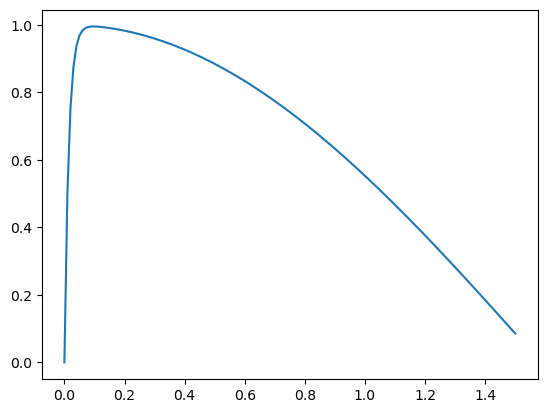

In [14]:
plt.plot(time,solution)